In [1]:

import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq
from dataclasses import dataclass
import hvplot.pandas 
# hv.renderer('bokeh').theme = 'dark_minimal'


# Data Loading
It is always a good advice to use standard formats to transfer data from one computer to another. One of the most used formats is parquet. The following code should help you to load the data into your python environment.

In [2]:
dataset_root = Path(r"./Dataset") # Raw string works without escaping \


@dataclass
class Case():
    info: pd.DataFrame
    measurements: pd.DataFrame


class RawDataset():

    def __init__(self, root, unit = "VG4", load_training=False, load_synthetic=False) -> None:
        
        
        read_pq_file = lambda f: pq.read_table(root / f).to_pandas()
        
        
        cases = {
            "test": [f"{unit}_generator_data_testing_real_measurements.parquet", root / f"{unit}_generator_data_testing_real_info.csv" ], 
        }
        
        if load_training:
            cases = {
                **cases,
                "train": [f"{unit}_generator_data_training_measurements.parquet", root / f"{unit}_generator_data_training_info.csv" ], 
            }
        
        if load_synthetic:
            cases = {
                **cases,
                "test_s01": [f"{unit}_generator_data_testing_synthetic_01_measurements.parquet", root / f"{unit}_generator_data_testing_synthetic_01_info.csv"], 
                "test_s02": [f"{unit}_generator_data_testing_synthetic_02_measurements.parquet", root / f"{unit}_generator_data_testing_synthetic_02_info.csv"]
            }
        
        
        self.data_dict = dict()
        
        for id_c, c in cases.items():
            # if you need to verify the parquet header:
            # pq_rows = RawDataset.read_parquet_schema_df(root / c[0])
            info = pd.read_csv(c[1])
            measurements = read_pq_file(c[0])
            self.data_dict[id_c] = Case(info, measurements)
            
        
        
    @staticmethod
    def read_parquet_schema_df(uri: str) -> pd.DataFrame:
        """Return a Pandas dataframe corresponding to the schema of a local URI of a parquet file.

        The returned dataframe has the columns: column, pa_dtype
        """
        # Ref: https://stackoverflow.com/a/64288036/
        schema = pq.read_schema(uri, memory_map=True)
        schema = pd.DataFrame(({"column": name, "pa_dtype": str(pa_dtype)} for name, pa_dtype in zip(schema.names, schema.types)))
        schema = schema.reindex(columns=["column", "pa_dtype"], fill_value=pd.NA)  # Ensures columns in case the parquet file has an empty dataframe.
        return schema
    



rds_u4 = RawDataset(dataset_root, "VG4", load_synthetic=False, load_training=True)
rds_u5 = RawDataset(dataset_root, "VG5", load_synthetic=True, load_training=True)
rds_u6 = RawDataset(dataset_root, "VG6", load_synthetic=True)




# Operation Modes

As you can see, the operation modes (at the very bottom) are not in the info schema, but you can find them when you explore the parquet schema (metadata of the parquet data file).

In [3]:
RawDataset.read_parquet_schema_df(dataset_root / "VG4_generator_data_testing_real_measurements.parquet")

column               pa_dtype
0                     tot_activepower                 double
1                           plant_tmp                 double
2                             ext_tmp                 double
3              water_primary_cold_tmp                 double
4               water_primary_hot_tmp                 double
5                       valve_opening                 double
6                    refri_bath_level                 double
7                     aspi_bath_level                 double
8                         canal_level                 double
9                           canal_tmp                 double
10  water_primary_filter_out_pressure                 double
11   water_primary_filter_in_pressure                 double
12                           lake_tmp                 double
13                   coupler_position                 double
14                  tot_reactivepower                 double
15                injector12_pressure                 double
16                injector34_pressure                 double
17                      pump_rotspeed                 double
18                injector_01_opening                 double
19                injector_02_opening                 double
20                injector_03_opening                 double
21                injector_04_opening                 double
22                   turbine_rotspeed                 double
23                           exc_freq                 double
24                        exc_current                 double
25                        exc_voltage                 double
26                        powerfactor                 double
27                          elec_freq                 double
28                       ph01_current                 double
29                       ph02_current                 double
30                       ph03_current                 double
31                       ph01_voltage                 double
32                       ph12_voltage                 double
33                       ph02_voltage                 double
34                       ph23_voltage                 double
35                       ph03_voltage                 double
36                       ph31_voltage                 double
37                   air_circ_hot_tmp                 double
38               air_circ_cold_01_tmp                 double
39               air_circ_cold_02_tmp                 double
40                   stat_magn_01_tmp                 double
41                   stat_magn_02_tmp                 double
42              stat_coil_ph01_01_tmp                 double
43              stat_coil_ph01_02_tmp                 double
44              stat_coil_ph02_01_tmp                 double
45              stat_coil_ph03_01_tmp                 double
46              stat_coil_ph03_02_tmp                 double
47              water_circ_hot_01_tmp                 double
48              water_circ_hot_02_tmp                 double
49                water_circ_cold_tmp                 double
50                         machine_on                   bool
51                        machine_off                   bool
52                       turbine_mode                   bool
53                                all                   bool
54           equilibrium_turbine_mode                   bool
55                        dyn_only_on                   bool
56                          pump_mode                   bool
57              equilibrium_pump_mode                   bool
58                  __index_level_0__  timestamp[ns, tz=CET]

We can use `head()` to glance at the data.

In [4]:
rds_u4.data_dict["train"].info.head()

Unnamed: 0                             signal_name          attribute_name  \
0           0               FMHL_SUP_VEY.MHL_VG4_G4_P         tot_activepower   
1           1    FMHL_SUP_VEY.MHL_VGE_PRAP_TEMP_USINE               plant_tmp   
2           2       FMHL_SUP_VEY.MHL_V2_EAU0_TEMP_EXT                 ext_tmp   
3           3  FMHL_SUP_VEY.MHL_VGE_PRAP_CLI_TEMP_DEP  water_primary_cold_tmp   
4           4  FMHL_SUP_VEY.MHL_VGE_PRAP_CLI_TEMP_RET   water_primary_hot_tmp   

       asset     unit    element  signal_type  control_signal  input_feature  \
0  Veytaux 1      VG4  Generator  Measurement           False           True   
1  Veytaux 1  General      Plant  Measurement           False          False   
2  Veytaux 1  General      Plant  Measurement           False          False   
3  Veytaux 1  General    Cooling  Measurement           False          False   
4  Veytaux 1  General    Cooling  Measurement           False          False   

   output_feature  core_attribute  
0            True           False  
1            True           False  
2            True           False  
3            True           False  
4            True           False

In [5]:
rds_u4.data_dict["train"].measurements.head()

tot_activepower  plant_tmp   ext_tmp  \
2020-01-02 00:00:00+01:00       -39.830002  16.516650  5.961580   
2020-01-02 00:00:30+01:00       -62.433334  16.554980  5.992895   
2020-01-02 00:01:00+01:00       -62.571904  16.593311  6.024210   
2020-01-02 00:01:30+01:00       -62.507894  16.631641  6.055526   
2020-01-02 00:02:00+01:00       -62.397368  16.669971  6.086841   

                           water_primary_cold_tmp  water_primary_hot_tmp  \
2020-01-02 00:00:00+01:00                   10.90              12.826471   
2020-01-02 00:00:30+01:00                   10.85              12.914706   
2020-01-02 00:01:00+01:00                   10.80              13.002564   
2020-01-02 00:01:30+01:00                   10.85              13.079487   
2020-01-02 00:02:00+01:00                   10.90              13.126829   

                           valve_opening  refri_bath_level  aspi_bath_level  \
2020-01-02 00:00:00+01:00      99.875000          2.956812         5.932592   
2020-01-02 00:00:30+01:00      99.873437          2.955667         5.927700   
2020-01-02 00:01:00+01:00      99.871875          2.960449         5.922808   
2020-01-02 00:01:30+01:00      99.870312          2.968310         5.917917   
2020-01-02 00:02:00+01:00      99.868750          2.979270         5.913025   

                           canal_level  canal_tmp  ...  water_circ_hot_02_tmp  \
2020-01-02 00:00:00+01:00   371.846035   9.000000  ...              16.882689   
2020-01-02 00:00:30+01:00   371.836559   8.912023  ...              16.797366   
2020-01-02 00:01:00+01:00   371.711225   8.824047  ...              16.712043   
2020-01-02 00:01:30+01:00   371.765866   8.736070  ...              16.626720   
2020-01-02 00:02:00+01:00   371.842773   8.648094  ...              16.369280   

                           water_circ_cold_tmp  machine_on  machine_off  \
2020-01-02 00:00:00+01:00            12.220884        True        False   
2020-01-02 00:00:30+01:00            12.095122        True        False   
2020-01-02 00:01:00+01:00            11.969360        True        False   
2020-01-02 00:01:30+01:00            11.825357        True        False   
2020-01-02 00:02:00+01:00            11.608393        True        False   

                           turbine_mode   all  equilibrium_turbine_mode  \
2020-01-02 00:00:00+01:00         False  True                     False   
2020-01-02 00:00:30+01:00         False  True                     False   
2020-01-02 00:01:00+01:00         False  True                     False   
2020-01-02 00:01:30+01:00         False  True                     False   
2020-01-02 00:02:00+01:00         False  True                     False   

                           dyn_only_on  pump_mode  equilibrium_pump_mode  
2020-01-02 00:00:00+01:00         True      False                  False  
2020-01-02 00:00:30+01:00         True       True                   True  
2020-01-02 00:01:00+01:00         True       True                   True  
2020-01-02 00:01:30+01:00         True       True                   True  
2020-01-02 00:02:00+01:00         True       True                   True  

[5 rows x 58 columns]

# Data Exploration
- Make sure that you explore the data in detail. For example, we will see that there is quite a big gap in operation from train to test if we look at the injector pressures of unit 4.
- To not overload our machine when plotting, we can use an index selection trick to downsample the data (since the dataframes are quite large) `[::100]`.
    - Please be aware that this is just to get some insights, we are only plotting every 100th step.

In [6]:
rds_u5.data_dict["train"].info

Unnamed: 0                                        signal_name  \
0            0                  FMHL_SUP_VEY.MHL_VG5_reEDSMT_P_MW   
1            1                  FMHL_SUP_VEY.MHL_V2_EAU0_TEMP_EXT   
2            2                FMHL_SUP_VEY.MHL_V2_EAU0_TEMP_USINE   
3            3                   FMHL_SUP_VEY.MHL_VG5_reMTU_CC_GT   
4            4                 FMHL_SUP_VEY.MHL_VG5_reMGP6_CPL_GT   
..         ...                                                ...   
86          86               FMHL_SUP_VEY.MHL_VG5_MPM1_AIR_GAP_XP   
87          87               FMHL_SUP_VEY.MHL_VG5_MPM1_AIR_GAP_YM   
88          88               FMHL_SUP_VEY.MHL_VG5_MPM1_AIR_GAP_YP   
89          89  FEAT.Veytaux_2.VG5.Control.Control_Feature.tim...   
90          90  FEAT.Veytaux_2.VG5.Control.Control_Feature.tim...   

                 attribute_name      asset     unit    element  signal_type  \
0               tot_activepower  Veytaux 2      VG5  Generator  Measurement   
1                       ext_tmp  Veytaux 2  General      Plant  Measurement   
2                     plant_tmp  Veytaux 2  General      Plant  Measurement   
3                        charge  Veytaux 2      VG5    Turbine  Measurement   
4              coupler_position  Veytaux 2      VG5    Coupler  Measurement   
..                          ...        ...      ...        ...          ...   
86  air_gap_positive_x_position  Veytaux 2      VG5  Generator  Measurement   
87  air_gap_negative_y_position  Veytaux 2      VG5  Generator  Measurement   
88  air_gap_positive_y_position  Veytaux 2      VG5  Generator  Measurement   
89         timer_turbine_on_off  Veytaux 2      VG5    Control      Feature   
90       timer_injector_opening  Veytaux 2      VG5    Control      Feature   

    control_signal  input_feature  output_feature  core_attribute  
0            False           True            True           False  
1            False          False            True           False  
2            False          False            True           False  
3             True          False            True           False  
4             True          False            True           False  
..             ...            ...             ...             ...  
86           False          False            True           False  
87           False          False            True           False  
88           False          False            True           False  
89            True          False           False           False  
90            True          False           False           False  

[91 rows x 11 columns]

There are quite many signals, so it makes sense to study them in groups. Here we focus on the temperatures `_tmp`), but you are supposed to look at all the other signals as well of course!

In [7]:
df = rds_u4.data_dict["train"].info
temperature_attrs = df[df.attribute_name.str.endswith("_tmp")]
temperature_attrs

Unnamed: 0                                  signal_name  \
1            1         FMHL_SUP_VEY.MHL_VGE_PRAP_TEMP_USINE   
2            2            FMHL_SUP_VEY.MHL_V2_EAU0_TEMP_EXT   
3            3       FMHL_SUP_VEY.MHL_VGE_PRAP_CLI_TEMP_DEP   
4            4       FMHL_SUP_VEY.MHL_VGE_PRAP_CLI_TEMP_RET   
9            9     FMHL_SUP_VEY.MHL_VGA_PRAP_TEMP_CAN_FUITE   
12          12            FMHL_SUP_VEY.MHL_VGE_CLI_TEMP_EAU   
37          37        FMHL_SUP_VEY.MHL_VG4_PRAP_ME_TEMP_AIC   
38          38    FMHL_SUP_VEY.MHL_VG4_PRAP_ME_TEMP_AIF_AMO   
39          39    FMHL_SUP_VEY.MHL_VG4_PRAP_ME_TEMP_AIF_AVA   
40          40      FMHL_SUP_VEY.MHL_VG4_PRAP_STAT_TEMP_FER   
41          41    FMHL_SUP_VEY.MHL_VG4_PRAP_STAT_TEMP_FER_2   
42          42     FMHL_SUP_VEY.MHL_VG4_PRAP_STAT_TEMP_PH_R   
43          43   FMHL_SUP_VEY.MHL_VG4_PRAP_STAT_TEMP_PH_R_2   
44          44     FMHL_SUP_VEY.MHL_VG4_PRAP_STAT_TEMP_PH_S   
45          45     FMHL_SUP_VEY.MHL_VG4_PRAP_STAT_TEMP_PH_T   
46          46   FMHL_SUP_VEY.MHL_VG4_PRAP_STAT_TEMP_PH_T_2   
47          47   FMHL_SUP_VEY.MHL_VG4_PRMGP_TEMP_AIR_ME_OUT   
48          48   FMHL_SUP_VEY.MHL_VG4_PRMGP_TEMP_AIR_TU_OUT   
49          49  FMHL_SUP_VEY.MHL_VG4_PRMGP_TEMP_EAU_REF_GR4   

            attribute_name      asset     unit    element  signal_type  \
1                plant_tmp  Veytaux 1  General      Plant  Measurement   
2                  ext_tmp  Veytaux 1  General      Plant  Measurement   
3   water_primary_cold_tmp  Veytaux 1  General    Cooling  Measurement   
4    water_primary_hot_tmp  Veytaux 1  General    Cooling  Measurement   
9                canal_tmp  Veytaux 1  General    Cooling  Measurement   
12                lake_tmp  Veytaux 1  General    Cooling  Measurement   
37        air_circ_hot_tmp  Veytaux 1      VG4  Generator  Measurement   
38    air_circ_cold_01_tmp  Veytaux 1      VG4  Generator  Measurement   
39    air_circ_cold_02_tmp  Veytaux 1      VG4  Generator  Measurement   
40        stat_magn_01_tmp  Veytaux 1      VG4  Generator  Measurement   
41        stat_magn_02_tmp  Veytaux 1      VG4  Generator  Measurement   
42   stat_coil_ph01_01_tmp  Veytaux 1      VG4  Generator  Measurement   
43   stat_coil_ph01_02_tmp  Veytaux 1      VG4  Generator  Measurement   
44   stat_coil_ph02_01_tmp  Veytaux 1      VG4  Generator  Measurement   
45   stat_coil_ph03_01_tmp  Veytaux 1      VG4  Generator  Measurement   
46   stat_coil_ph03_02_tmp  Veytaux 1      VG4  Generator  Measurement   
47   water_circ_hot_01_tmp  Veytaux 1      VG4  Generator  Measurement   
48   water_circ_hot_02_tmp  Veytaux 1      VG4  Generator  Measurement   
49     water_circ_cold_tmp  Veytaux 1      VG4  Generator  Measurement   

    control_signal  input_feature  output_feature  core_attribute  
1            False          False            True           False  
2            False          False            True           False  
3            False          False            True           False  
4            False          False            True           False  
9            False          False            True           False  
12           False          False            True           False  
37           False          False            True           False  
38           False          False            True           False  
39           False          False            True           False  
40           False          False            True           False  
41           False          False            True           False  
42           False          False            True           False  
43           False          False            True           False  
44           False          False            True           False  
45           False          False            True           False  
46           False          False            True           False  
47           False          False            True           False  
48           False          False     

We can use pandas to directly plot the data. Usually, panda uses matplotlib, but when we install the hvplot module, we can have a much nicer html data explorer.

<Axes: >

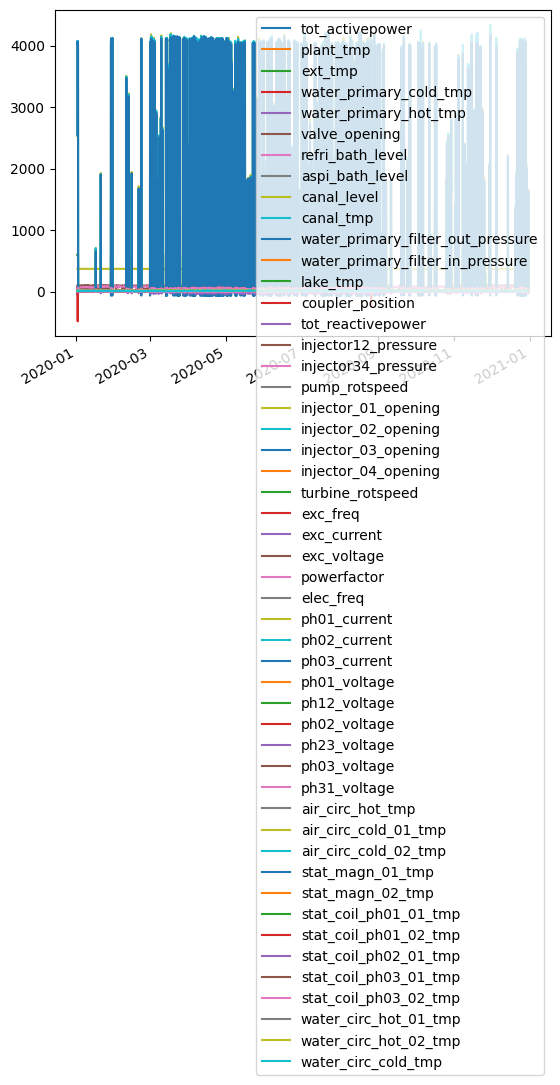

In [8]:
rds_u4.data_dict["train"].measurements[::100].plot()

In [9]:
rds_u4.data_dict["train"].measurements[::100].hvplot.explorer(y=[v for v in temperature_attrs.attribute_name.values])

BokehModel(combine_events=True, render_bundle={'docs_json': {'00f4bcd6-981f-49ec-a382-34b68aef1280': {'version…

An other example would be to look at injector pressures:

In [10]:
df = rds_u4.data_dict["train"].info
temperature_attrs = df[df.attribute_name.str.contains("injector")]
temperature_attrs

Unnamed: 0                                        signal_name  \
15          15           FMHL_SUP_VEY.MHL_VG4_PRMTU_PRES_EAU_PT12   
16          16           FMHL_SUP_VEY.MHL_VG4_PRMTU_PRES_EAU_PT34   
18          18          FMHL_SUP_VEY.MHL_VG4_MIPMTU_PT1_OUVERTURE   
19          19          FMHL_SUP_VEY.MHL_VG4_MIPMTU_PT2_OUVERTURE   
20          20          FMHL_SUP_VEY.MHL_VG4_MIPMTU_PT3_OUVERTURE   
21          21          FMHL_SUP_VEY.MHL_VG4_MIPMTU_PT4_OUVERTURE   
50          50  FEAT.Veytaux_1.VG4.Control.Control_Feature.tim...   

            attribute_name      asset unit  element  signal_type  \
15     injector12_pressure  Veytaux 1  VG4     MIV1  Measurement   
16     injector34_pressure  Veytaux 1  VG4     MIV2  Measurement   
18     injector_01_opening  Veytaux 1  VG4  Turbine  Measurement   
19     injector_02_opening  Veytaux 1  VG4  Turbine  Measurement   
20     injector_03_opening  Veytaux 1  VG4  Turbine  Measurement   
21     injector_04_opening  Veytaux 1  VG4  Turbine  Measurement   
50  timer_injector_opening  Veytaux 1  VG4  Control      Feature   

    control_signal  input_feature  output_feature  core_attribute  
15            True          False            True           False  
16            True          False            True           False  
18            True          False            True           False  
19            True          False            True           False  
20            True          False            True           False  
21            True          False            True           False  
50            True          False           False           False

In [11]:
rds_u4.data_dict["train"].measurements[::100].hvplot.explorer(y=["injector12_pressure", "injector34_pressure"])

BokehModel(combine_events=True, render_bundle={'docs_json': {'2bd4d3ce-cf88-4b66-ba8e-35b46875eafd': {'version…

As you can see, the test set is quite short compared to the training set. For injector 1, the test distribution is different compared to the training distribution (distribution shift).
Be aware that such distribution shifts can greatly influence the performance of your model.

In [12]:
rds_u4.data_dict["test"].measurements[::100].hvplot.explorer(y=["injector12_pressure", "injector34_pressure"])

BokehModel(combine_events=True, render_bundle={'docs_json': {'690dc1b5-d9b2-4874-a9ec-473a732cce63': {'version…

We can also explore the machines in operation next to each other:

The training data sets.

In [13]:
plt = (
    rds_u4.data_dict["train"].measurements[::1000].hvplot()
    + rds_u5.data_dict["train"].measurements[::1000].hvplot()
    ).cols(1)

plt

:Layout
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [index]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Curve   [index]   (value)

We see that the test datasets are recorded troughout different seasons, which can have an impact on the recorded data.

In [ ]:
plt = (
    rds_u4.data_dict["test"].measurements[::1000].hvplot()
    + rds_u5.data_dict["test"].measurements[::1000].hvplot()
    + rds_u6.data_dict["test"].measurements[::1000].hvplot()
    ).cols(1)

plt

Now it's your turn. Try to explore the data as much as possible before engineering the solution. The main difficulty in real-world problems often isn't the complexity, but understanding the actual problem you are trying to solve, as there is no "guidance" like in the exercises you saw throughout this class. Remember, there are always trade-offs when selecting a model which you should evaluate before investing a lot of time on the implementation.